In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from Dnn_utils import  sigmoid, sigmoid_backward, relu, relu_backward
from shallowData import load_dataset
%matplotlib inline

In [2]:
train_set_x_orig, test_set_x_orig,train_set_y,test_set_y, classes = load_dataset()

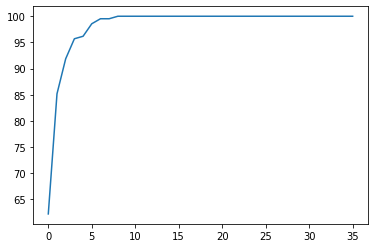

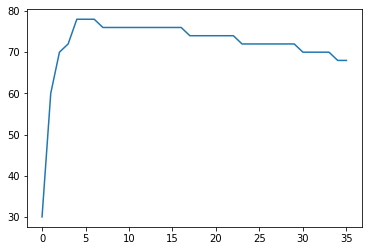

Train accuracy100.0%
Test accuracy68.0%


In [11]:
train_set_x_flat=train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
train_set_x=train_set_x_flat/255

test_set_x_flat=test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_set_x=test_set_x_flat/255

def layer_sizes(X,Y):
    n_x=X.shape[0]
    n_y=Y.shape[0]
    return n_x,n_y
def initialize_parameters(layer_dims):
    parameters={}
    for i in range(1,len(layer_dims)):
        parameters["W"+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/layer_dims[i-1])
        parameters["b"+str(i)]=np.zeros((layer_dims[i],1))
    return parameters
def linear_forward(W,A,b):
    D=0
    Z=np.dot(W,A)+b
    cache=(W,A,b,D)
    return Z,cache
def linear_forward_with_dropout(W,A,b,keep_prob):
    D=np.random.rand(A.shape[0],A.shape[1])
    D=(D<keep_prob).astype(int)   #keep nodes with probability=keep_prob
    A=A*D
    A=A/keep_prob   #divided by keep_prob to keep output same
    Z=np.dot(W,A)+b
    cache=(W,A,b,D)
    return Z,cache
def linear_activation_forward_with_dropout(W,A_prev,b,activation,keep_prob):
    if(activation=="relu"):
        Z,linear_cache=linear_forward_with_dropout(W,A_prev,b,keep_prob)
        A,activation_cache=relu(Z)
    elif(activation=="sigmoid"):
        Z,linear_cache=linear_forward_with_dropout(W,A_prev,b,keep_prob)
        A,activation_cache = sigmoid(Z)
    cache=(linear_cache,activation_cache)
    return A,cache

def linear_activation_forward(W,A_prev,b,activation):
    if(activation=="relu"):
        Z,linear_cache=linear_forward(W,A_prev,b)
        A,activation_cache=relu(Z)
    elif(activation=="sigmoid"):
        Z,linear_cache=linear_forward(W,A_prev,b)
        A,activation_cache = sigmoid(Z)
    cache=(linear_cache,activation_cache)
    return A,cache
def L_model_forward_with_dropout(X,parameters,keep_prob):
    caches=[]
    A=X
    L=len(parameters)//2
    for i in range(1,L):
        if(i>1):
            A,cache=linear_activation_forward_with_dropout(parameters["W"+str(i)],A,parameters["b"+str(i)],"relu",keep_prob[i-1])
            caches.append(cache)
        else:
            A,cache=linear_activation_forward(parameters["W"+str(i)],A,parameters["b"+str(i)],"relu")
            caches.append(cache)
    A,cache=linear_activation_forward(parameters["W"+str(L)],A,parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    AL=A
    return AL,caches
def L_model_forward(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for i in range(1,L):
        A,cache=linear_activation_forward(parameters["W"+str(i)],A,parameters["b"+str(i)],"relu")
        caches.append(cache)
    A,cache=linear_activation_forward(parameters["W"+str(L)],A,parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    AL=A
    return AL,caches

def linear_backward(dZ,cache):
    W,A_prev,b,D=cache
    m=A_prev.shape[1]
    dW=np.dot(dZ,A_prev.T)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dW,dA_prev,db
def linear_backward_with_dropout(dZ,cache,keep_prob):
    W,A_prev,b,D=cache
    m=A_prev.shape[1]
    dW=np.dot(dZ,A_prev.T)/m
    dW=dW*D
    dW=dW/keep_prob
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dW,dA_prev,db
def linear_activation_backward_with_dropout(dA,cache,activation,keep_prob):
    linear_cache,activation_cache=cache
    if(activation=="relu"):
        dZ=relu_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward_with_dropout(dZ,linear_cache,keep_prob)
    elif(activation=="sigmoid"):
        dZ=sigmoid_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward_with_dropout(dZ,linear_cache,keep_prob)
    return dW,dA_prev,db

def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache=cache
    if(activation=="relu"):
        dZ=relu_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward(dZ,linear_cache)
    elif(activation=="sigmoid"):
        dZ=sigmoid_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward(dZ,linear_cache)
    return dW,dA_prev,db
def L_model_backward_with_dropout(AL,Y,caches,keep_prob):#caches is(linear_cache,activation_cache)
    L=len(caches)
    m=AL.shape[1]
    grads={}
    current_cache=caches[L-1]
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    grads["dW"+str(L)],grads["dA"+str(L-1)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,"sigmoid")
    for l in reversed(range(L-1)):
        if(l>1):
            current_cache=caches[l]
            grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_activation_backward_with_dropout(grads["dA"+str(l+1)],current_cache,"relu",keep_prob[l-1])    
        else:
            current_cache=caches[l]
            grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
    return grads
def L_model_backward(AL,Y,caches):#caches is(linear_cache,activation_cache)
    L=len(caches)
    m=AL.shape[1]
    grads={}
    current_cache=caches[L-1]
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    grads["dW"+str(L)],grads["dA"+str(L-1)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,"sigmoid")
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
    return grads    

def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for i in range(1,L+1):
          parameters["W"+str(i)]=parameters["W"+str(i)]-learning_rate*grads["dW"+str(i)]
          parameters["b"+str(i)]=parameters["b"+str(i)]-learning_rate*grads["db"+str(i)]
    return parameters
def predict(parameters,X):
    AL,caches=L_model_forward(X,parameters)
    Y_prediction=np.round(AL)
    return Y_prediction
  
def train_model(X_train,Y_train,layer_dims,num_iterations,learning_rate,keep_prob):
    parameters=initialize_parameters(layer_dims)
    train=[]
    test=[]
    for i in range(num_iterations):
        AL,caches=L_model_forward_with_dropout(X_train,parameters,keep_prob)
        grads=L_model_backward_with_dropout(AL,Y_train,caches,keep_prob)
        param=update_parameters(parameters,grads,learning_rate)
        if(i%250==0):
            Y_train_prediction=predict(parameters,train_set_x)
            train.append(100-np.mean(np.abs(Y_train_prediction-train_set_y))*100)
            Y_test_prediction=predict(parameters,test_set_x)
            test.append(100-np.mean(np.abs(Y_test_prediction-test_set_y))*100)
    plt.plot(train)
    plt.show()
    plt.plot(test)
    plt.show()
    return param
n_x,n_y=layer_sizes(train_set_x,train_set_y)
d=train_model(train_set_x,train_set_y,[n_x,10,n_y],9000,0.0025,[1,0.5,1.0])
Y_train_prediction=predict(d,train_set_x)
Y_test_prediction=predict(d,test_set_x)
print("Train accuracy{}%".format(100-np.mean(np.abs(Y_train_prediction-train_set_y))*100))
print("Test accuracy{}%".format(100-np.mean(np.abs(Y_test_prediction-test_set_y))*100))


          
        
        
        
    